In [1]:
import numpy as np
import rasterio
from rasterio import Affine
from rasterio.warp import calculate_default_transform, \
reproject, Resampling
import matplotlib.pyplot as plt
from GISops import project_raster

%matplotlib inline

In [2]:
kde_raster = '../Hannah_example/kde_aniso_onlyeruption_mafic.txt'

In [3]:
meta = {}
with open(kde_raster) as input:
    for i in range(6):
        line = next(input).strip().split()
        meta[line[0]] = line[1]
meta

{'NODATA_value': '-9999.000000',
 'cellsize': '100.000000',
 'ncols': '741',
 'nrows': '901',
 'xllcorner': '544000.000000',
 'yllcorner': '2640000.000000'}

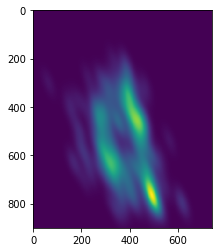

In [4]:
kde = np.loadtxt(kde_raster, skiprows=6)
plt.imshow(kde)

In [5]:
xll = float(meta['xllcorner'])
yll = float(meta['yllcorner'])
cellsize = float(meta['cellsize'])
xur = xll + cellsize * kde.shape[1]
yur = yll + cellsize * kde.shape[0]
xll, yur

(544000.0, 2730100.0)

In [6]:
src_crs='+init=epsg:32637' # UTM zone 37 N
dst_crs='+init=epsg:4326' # wgs84 degrees
src_transform = Affine(cellsize, 0., xll,
                       0., -cellsize, yur)
dst_transform, width, height = calculate_default_transform(src_crs=src_crs,
                                                    dst_crs=dst_crs,
                                                    width=kde.shape[1], 
                                                    height=kde.shape[0],
                                                    bottom=yll, left=xll, right=xur, top=yur)
dst_transform

Affine(0.0009366458176494151, 0.0, 39.43216510373904,
       0.0, -0.0009366458176494151, 24.684650247907)

In [7]:
top = dst_transform[5]
left = dst_transform[2]
bottom = top + dst_transform[4] * height
right = left + dst_transform[0] * width
left, bottom, right, top

(39.43216510373904, 23.866958449099062, 40.167432070593826, 24.684650247907)

### Write it out to a GeoTiff

In [8]:
out_meta = {'count': 1,
         'crs': dst_crs,
         'transform': dst_transform,
         'width': width,
         'height': height,
         'driver': 'GTiff',
         'dtype': kde.dtype
         }
with rasterio.open('data/kde.tif', 'w', **out_meta) as dst:
    reproject(
        source=kde, 
        destination=rasterio.band(dst, 1), # write to band 1
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
        num_threads=2)

### View using `folium`

In [9]:
import folium
from folium import plugins
import branca.colormap as cm

In [10]:
y, x = np.mean((bottom, top)), np.mean((left, right))
x, y

(39.799798587166435, 24.27580434850303)

In [11]:
m = folium.Map(location=[y, x], zoom_start=10,
               tiles='Stamen Terrain')
plugins.ImageOverlay(kde,
                     [[bottom, left], 
                      [top, right]], opacity=0.5).add_to(m)
#colormap = cm.linear.Set1.scale(kde.min(), kde.max()).to_step(10)
cmap = cm.LinearColormap(['white', 'black'],
                           vmin=kde.min(), vmax=kde.max())
cmap.caption = 'Probability'
m.add_child(cmap)
m